In [29]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import sqlalchemy
import seaborn as sns  
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, MetaData, inspect, func
from sqlalchemy import Column, Integer, String, Numeric, Text, Float
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import cast, Integer
from flask import Flask, jsonify   

In [30]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [31]:
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys() 

['measurement', 'station']

In [32]:
conn = engine.connect()                                 
inspector = inspect(engine)

In [33]:
Measurement = Base.classes.measurement
Station = Base.classes.station

In [34]:
session = Session(engine)   

In [35]:
precip_analysis = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= "2016-08-24").\
    filter(Measurement.date <= "2017-08-23").all()

In [36]:
precip_analysis

[('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06', 0.0),
 ('2016-10-07'

In [37]:
precip_df = pd.DataFrame(precip_analysis)

In [38]:
precip_df['date'] = pd.to_datetime(precip_df['date'])

In [39]:
precip_df = precip_df.set_index('date')                                      
precip_df.rename(columns = {'prcp': 'precipitation'}, inplace=True) 
precip_df.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


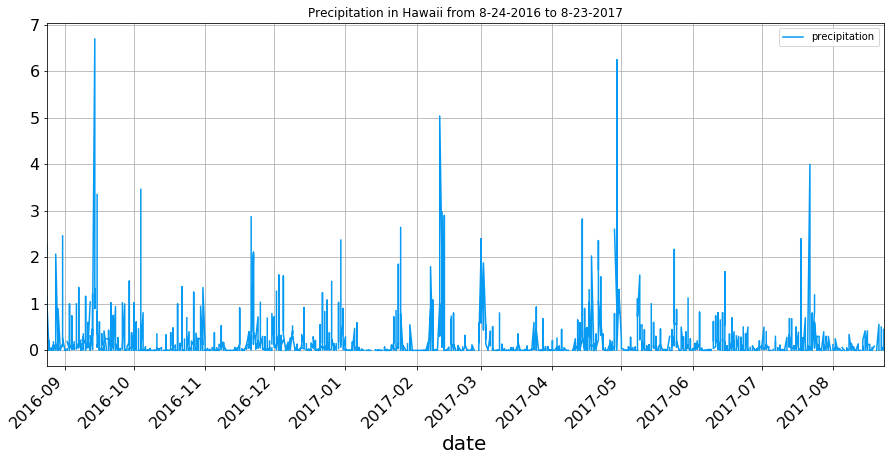

In [40]:
precip_df.plot(figsize=(15, 7),                                             
               sort_columns=True, 
               rot=45, 
               use_index=True, 
               title='Precipitation in Hawaii from 8-24-2016 to 8-23-2017', 
               legend=True,
               fontsize=16,
               grid=True,
               color='xkcd:azure'
              )

plt.xlabel('date', fontsize=20)
plt.show()

In [41]:
precip_df.describe()  

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [42]:
station_count = session.query(Station.id).count()                           
print(f'There are {station_count} weather stations in Hawaii.')

There are 9 weather stations in Hawaii.


In [43]:
station_activity = session.query(Measurement.station, Station.name, func.count(Measurement.tobs)).\
filter(Measurement.station == Station.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

In [44]:
station_activity 

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [45]:
station_activity[0]  

('USC00519281', 'WAIHEE 837.5, HI US', 2772)

In [46]:
for row in reversed(station_activity):                  
    most_active_station=row.station
    most_active_name=str(row.name)

In [47]:
most_active_station_tobs = session.query(Measurement.tobs).\
filter(Measurement.station == most_active_station, Measurement.station == Station.station,\
       Measurement.date >="2016-08-24", Measurement.date <="2017-08-23").all()

In [48]:
temperatures = [temp[0] for temp in most_active_station_tobs] 

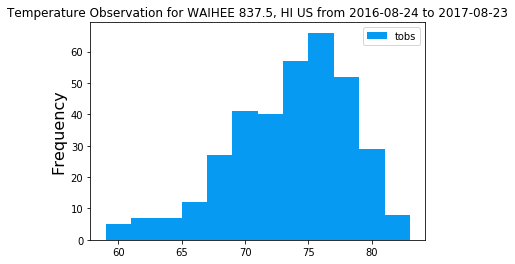

In [49]:
plt.hist(temperatures, bins=12, color='xkcd:azure')                          
plt.title("Temperature Observation for %s from 2016-08-24 to 2017-08-23" % (most_active_name))
plt.ylabel('Frequency', fontsize=16)
labels = ['tobs']
plt.legend(labels)
plt.show()

In [50]:
def calc_temps(start, end):
    """ function calc_temps
        parameters: start (string), end (string)
        returns: list
        extracts data using a SQL Alchemy query and returns list
        of avg temperature, lowest temperature, highest temperature
    """
    temp_list = []
    query = session.query(Measurement.tobs).filter(Measurement.date>=start, Measurement.date<=end).all()
    temperatures = [temp[0] for temp in query]
    temp_list.append(np.mean(temperatures))
    temp_list.append(min(temperatures))
    temp_list.append(max(temperatures))
    
    return temp_list

In [51]:
def get_prev_year_date(target):
    """ function get_prev_year_date
        parameters: target (string)
        returns: string
        disassembles string and subtracts 1 from year portion
        returns parameter input on error
    """
    try:
        xl = target.split('-')
        xc = (str(int(xl[0])-1)) + '-' + xl[1] + '-' + xl[2]
        return xc
    except:
        return target

In [53]:
trip_start_date = '2018-07-01'
trip_end_date = '2018-07-11'

In [54]:
start_conv = get_prev_year_date(trip_start_date)                             # gets previous year start and end dates
end_conv = get_prev_year_date(trip_end_date)

In [55]:
temp_list = calc_temps(start_conv, end_conv)   

In [56]:
temp_list  

[78.03030303030303, 69.0, 87.0]

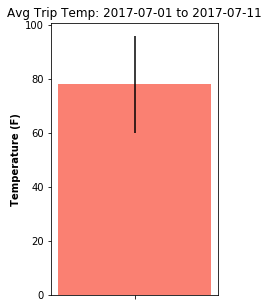

In [57]:
plt.figure(figsize=(3,5))                                                    # plots data
plt.bar(1, temp_list[0], yerr=(temp_list[2] - temp_list[1]), tick_label='', color='salmon')
plt.ylabel("Temperature (F)", weight="bold")
plt.title("Avg Trip Temp: %s to %s" % (start_conv, end_conv))
plt.show()